In [715]:
# Import of all librairies needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
from datetime import datetime, date
from scipy.stats import skew, kurtosis
from scipy.stats import norm
import requests
import warnings
warnings.filterwarnings('ignore')

# Question 1

In [716]:
stocks = ['MMM', 'AOS', 'ABT', 'ADM', 'ADBE', 'ADP', 'AES', 'AFL', 'A', 'AKAM']
start_date = '2000-01-01'
end_date = '2022-12-31'

In [717]:
# Import of monthly prices for interest stocks
stocks_prices = yf.download(tickers=stocks, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
monthly_prices = stocks_prices.resample('M').last()
monthly_prices

[*********************100%***********************]  10 of 10 completed



Ticker,A,ABT,ADBE,ADM,ADP,AES,AFL,AKAM,AOS,MMM
Date,,,,,,,,,,
2000-01-31,39.632824,7.604779,13.668240,5.938100,21.863295,25.872000,6.506685,249.125000,2.074736,19.190075
2000-02-29,62.199951,7.706956,25.319601,5.106566,20.077368,27.062687,5.487390,261.250000,1.812110,18.192648
2000-03-31,62.274792,8.217834,27.638033,5.233436,22.282837,25.428019,6.838128,160.812500,1.890899,18.270012
2000-04-30,53.068306,9.021887,30.027847,5.043128,24.851713,29.040422,7.325897,98.875000,2.173728,17.870308
2000-05-31,44.086361,9.549994,27.948400,6.087614,25.400129,28.172632,7.770921,66.750000,2.219978,17.804470
...,...,...,...,...,...,...,...,...,...,...
2022-08-31,125.258003,96.378159,373.440002,80.127136,228.156448,22.167225,55.578773,90.279999,53.139278,91.927391
2022-09-30,118.714325,90.848038,275.200012,73.344261,212.060486,19.684843,52.566940,80.320000,45.730846,81.688591
2022-10-31,135.356232,93.333168,318.500000,88.414268,226.601624,22.922520,60.900955,88.330002,51.867031,92.991928


**Mean Variance Portfolio (MVP)**
$$
w^* = \frac{\Sigma^{-1}\mu}{\mathbf{1}^\top \Sigma^{-1}\mu}
$$

In [718]:
# Estimation window (60 months of monthly returns)
window = 60

In [719]:
def weights_mvp(window_data, reg=1e-8):
    # Compute monthly expected returns and covariance matrix
    mu = window_data.mean().values                
    cov = window_data.cov().values                 

    # Regularize covariance for numerical stability
    cov = cov + reg * np.eye(cov.shape[0])
    inv_cov = np.linalg.pinv(cov)
    ones = np.ones(len(mu))

    # Tangency (MVP) weights proportional to Sigma^{-1} mu, then normalized to sum to 1
    numerator = inv_cov @ mu
    denom = ones @ inv_cov @ mu
    weights = numerator / denom

    return pd.Series(weights, index=window_data.columns)

In [720]:
monthly_rets = monthly_prices.pct_change().dropna() # Simple returns

# Itering through a loop to apply weight_mvp on a rolling window
weights_rolled_mvp = []
for idx in range(window, monthly_rets.shape[0]):
    window_data = monthly_rets.iloc[idx-window:idx]
    weights = weights_mvp(window_data)
    weights_rolled_mvp.append(weights)

weights_mvp_rolled = pd.DataFrame(weights_rolled_mvp, index=monthly_rets.index[window:])

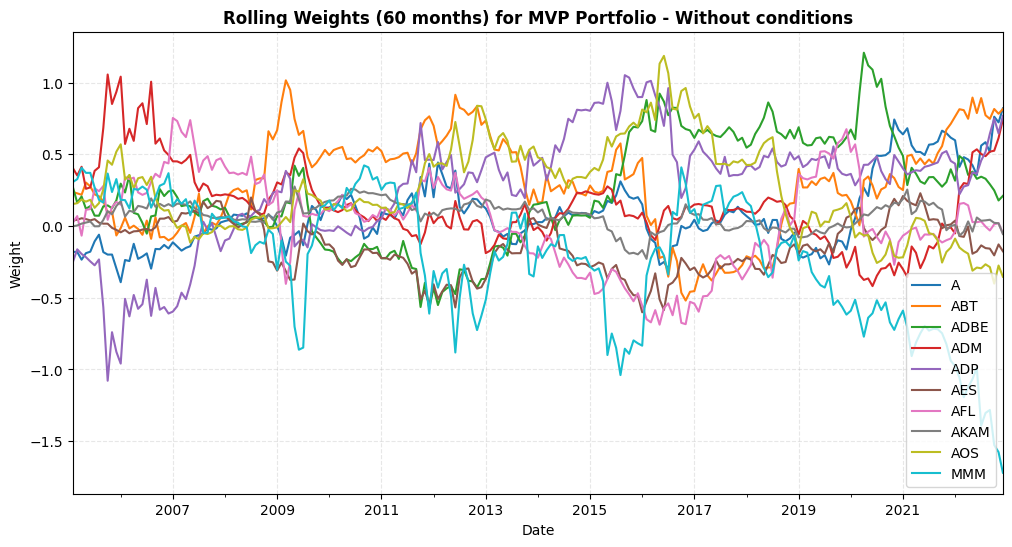

In [721]:
# Plot of the rolling weights of the mvp portfolio through time 
weights_mvp_rolled.plot(figsize=(12,6))
plt.title(f'Rolling Weights ({window} months) for MVP Portfolio - Without conditions', fontweight='bold')
plt.ylabel('Weight')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3, linestyle='--')

In [722]:
# Function to compute the weights of the GMV
def weights_gmv(window_data):
    cov = window_data.cov()
    ones = np.ones(window_data.shape[1])
    inv_cov = np.linalg.pinv(cov)
    weights = (inv_cov @ ones) / (ones @ inv_cov @ ones.T)
    return pd.Series(weights, index=window_data.columns)

In [723]:
# Itering through a loop to apply weight_gmv on a rolling window
weights_rolled_gmv = []
for idx in range(window, monthly_rets.shape[0]):
    window_data = monthly_rets.iloc[idx-window:idx]
    weights = weights_gmv(window_data)
    weights_rolled_gmv.append(weights)

weights_gmv_rolled = pd.DataFrame(weights_rolled_gmv, index=monthly_rets.index[window:])

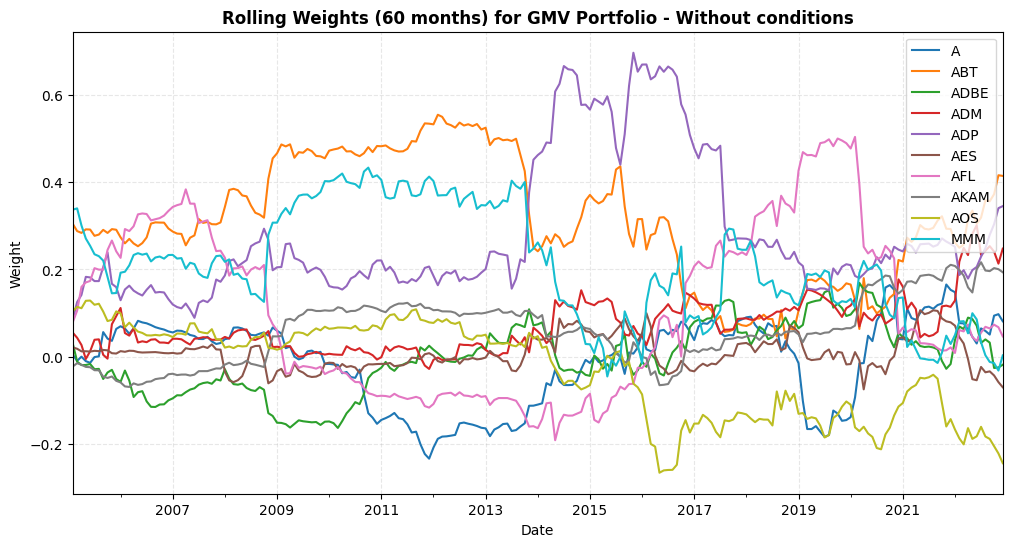

In [724]:
# Plot of the rolling weights for the gmv portfolio through time 
weights_gmv_rolled.plot(figsize=(12,6))
plt.title(f'Rolling Weights ({window} months) for GMV Portfolio - Without conditions', fontweight='bold')
plt.ylabel('Weight')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3, linestyle='--')

In [725]:
# Align returns at t+1 with weights at t
monthly_rets_OOS = monthly_rets.shift(-1).iloc[window:]

# Out-of-sample returns
rets_OOS_mvp = (weights_mvp_rolled * monthly_rets_OOS).sum(axis=1)

In [726]:
# Estimation of out-of-sample performance for GMV portfolio
rets_OOS_gmv = (weights_gmv_rolled * monthly_rets_OOS).sum(axis=1)

In [727]:
# Calculation of Sharpe Ratios for both strategies
oos_sharpe_mvp = (rets_OOS_mvp.mean() / rets_OOS_mvp.std()) * np.sqrt(12)
oos_sharpe_gmv = (rets_OOS_gmv.mean() / rets_OOS_gmv.std()) * np.sqrt(12)

# Print results
results = pd.DataFrame({
    "Sharpe Ratio": [
        oos_sharpe_mvp,
        oos_sharpe_gmv
    ]
}, index=["MVP", "GMV"])

print(results.round(4))

     Sharpe Ratio
MVP        0.6052
GMV        0.8088


We are know adding constraints to the portfolios imposing a nonnegativity on the weights :

**Global Minimum Variance (GMV-C)**
$$
\begin{aligned}
\min_{w} \quad & w^\top \Sigma \, w \\
\text{s.t.} \quad & \mathbf{1}^\top w = 1, \\
                  & w_i \ge 0 \quad \forall i.
\end{aligned}
$$

In [728]:
# We compute the weights of the GMV portfolio by solving a minimization problem

def weights_gmv_c(window_data):
    cov = window_data.cov().values

    # Define the objective function
    def objective(w):
        return w.T @ cov @ w
    
    # Define the constraints
    constraints = ({
        'type': 'eq',
        'fun' : lambda w: np.sum(w) - 1
    })

    # Bounds : no short selling
    bounds = [(0, 1) for idx in range(cov.shape[0])]

    # Initial guess
    w0 = np.ones(cov.shape[0]) / cov.shape[0]

    # Run the optimizer
    res = minimize(objective, w0, bounds=bounds, constraints=constraints)

    # Print results
    return pd.Series(res.x, index = window_data.columns)

**Minimum Variance Portfolio (MVP-C)**

In [729]:
# We compute the weights of the MVP portfolio by solving a minimization problem

def weights_mvp_c(window_data):
    cov = window_data.cov().values
    mu = window_data.mean().values  

    # Define the objective function
    def objective(w):
        ret = w @ mu
        vol = np.sqrt(w.T @ cov @ w)
        return - ret / vol 
    
    # Define the constraints
    constraints = ({
        'type': 'eq',
        'fun' : lambda w: np.sum(w) - 1
    })

    # Bounds : no short selling
    bounds = [(0, 1) for idx in range(cov.shape[0])]

    # Initial guess
    w0 = np.ones(cov.shape[0]) / cov.shape[0]

    # Run the optimizer
    res = minimize(objective, w0, bounds=bounds, constraints=constraints)

    # Print results
    return pd.Series(res.x, index = window_data.columns)

In [730]:
monthly_rets = monthly_prices.pct_change().dropna() # Simple returns

# Itering through a loop to apply weight_mvp_c on a rolling window
weights_rolled_c_mvp = []
for idx in range(window, monthly_rets.shape[0]):
    window_data = monthly_rets.iloc[idx-window:idx]
    weights = weights_mvp_c(window_data)
    weights_rolled_c_mvp.append(weights)

weights_mvp_c_rolled = pd.DataFrame(weights_rolled_c_mvp, index=monthly_rets.index[window:])

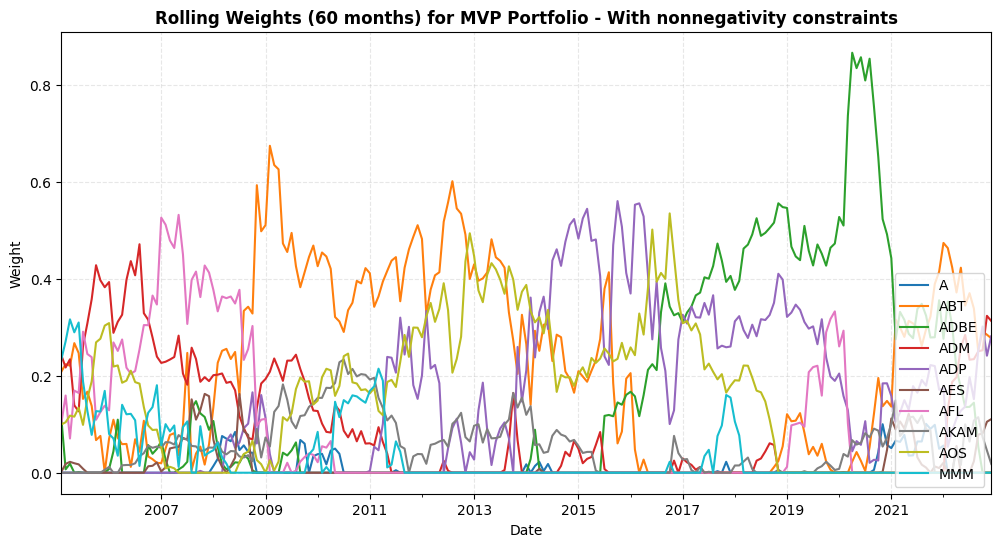

In [731]:
# Plot of the rolling weights of the mvp_c portfolio through time 
weights_mvp_c_rolled.plot(figsize=(12,6))
plt.title(f'Rolling Weights ({window} months) for MVP Portfolio - With nonnegativity constraints', fontweight='bold')
plt.ylabel('Weight')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3, linestyle='--')

In [732]:
# Itering through a loop to apply weight_gmv_c on a rolling window
weights_rolled_c_gmv = []
for idx in range(window, monthly_rets.shape[0]):
    window_data = monthly_rets.iloc[idx-window:idx]
    weights = weights_gmv_c(window_data)
    weights_rolled_c_gmv.append(weights)

weights_gmv_c_rolled = pd.DataFrame(weights_rolled_c_gmv, index=monthly_rets.index[window:])

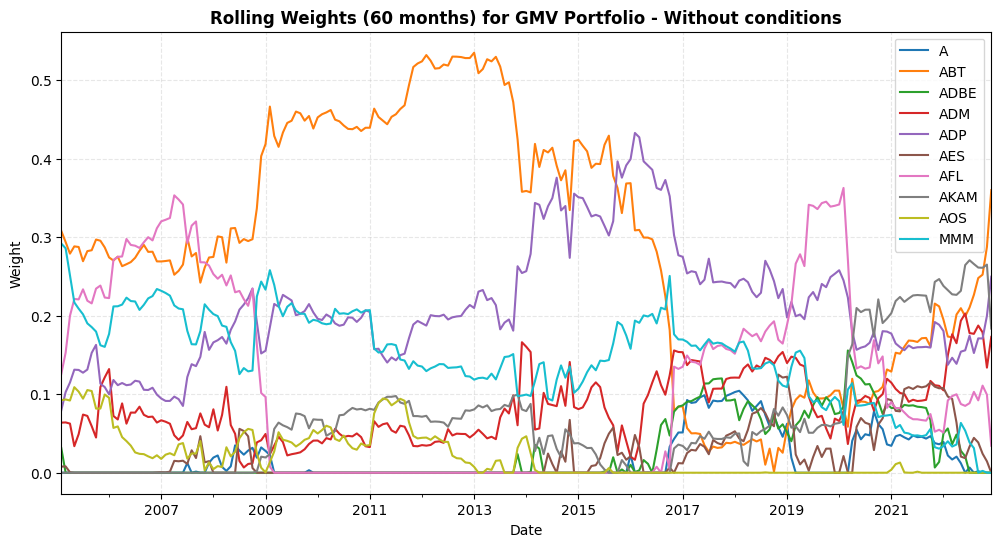

In [733]:
# Plot of the rolling weights for the gmv_c portfolio through time 
weights_gmv_c_rolled.plot(figsize=(12,6))
plt.title(f'Rolling Weights ({window} months) for GMV Portfolio - Without conditions', fontweight='bold')
plt.ylabel('Weight')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3, linestyle='--')

In [734]:
# Out-of-sample returns
rets_OOS_mvp_c = (weights_mvp_c_rolled * monthly_rets_OOS).sum(axis=1)

# Estimation of out-of-sample performance for GMV portfolio
rets_OOS_gmv_c = (weights_gmv_c_rolled * monthly_rets_OOS).sum(axis=1)

In [735]:
# Calculation of Sharpe Ratios for both strategies
oos_sharpe_mvp_c = (rets_OOS_mvp_c.mean() / rets_OOS_mvp_c.std()) * np.sqrt(12)
oos_sharpe_gmv_c = (rets_OOS_gmv_c.mean() / rets_OOS_gmv_c.std()) * np.sqrt(12)

# Print results
results = pd.DataFrame({
    "Sharpe Ratio": [
        oos_sharpe_mvp_c,
        oos_sharpe_gmv_c
    ]
}, index=["MVP_C", "GMV_C"])

print(results.round(4))

       Sharpe Ratio
MVP_C        0.8393
GMV_C        0.8204
